In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import textwrap
import torch

from collections import Counter
from itertools import product
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mc_ccr import MultiClassCCR as CCR
from PIL import Image
from pytorch_tabnet.tab_model import TabNetClassifier as TNC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from xgboost import XGBClassifier as XGBC

In [2]:
SEED = 42

In [3]:
def get_species(exclude_unclassified_and_viruses=True):
    df_4347 = pd.read_csv('input/4347_final_relative_abundances.txt', sep='\t')
    df_val = pd.read_csv('input/validation_abundance.csv')
    
    if exclude_unclassified_and_viruses:
        df_4347 = df_4347[~df_4347['Unnamed: 0'].str.contains('unclassified')]
        df_4347 = df_4347[~df_4347['Unnamed: 0'].str.contains('virus')]

        df_val = df_val[~df_val['Species'].str.contains('unclassified')]
        df_val = df_val[~df_val['Species'].str.contains('virus')]

    s1 = list(df_4347.transpose().iloc[0])
    s2 = list(df_val.transpose().iloc[0])
    
    return sorted(list(set(s1 + s2)))

species = get_species()
species[:10]

['s__Abiotrophia_defectiva',
 's__Achromobacter_piechaudii',
 's__Achromobacter_xylosoxidans',
 's__Acidaminococcus_fermentans',
 's__Acidaminococcus_intestini',
 's__Acidaminococcus_sp_BV3L6',
 's__Acidaminococcus_sp_D21',
 's__Acidaminococcus_sp_HPA0509',
 's__Acinetobacter_baumannii',
 's__Acinetobacter_beijerinckii']

In [4]:
def get_classes():
    df = pd.read_csv('input/4347_final_relative_abundances.txt', sep='\t')
    
    return list(set([x.split('_')[0] for x in df.columns[1:]]))

classes = get_classes()
classes

['Overweight',
 'ACVD',
 'CRC',
 'advanced adenoma',
 'Crohns disease',
 'IGT',
 'Ulcerative colitis',
 'Underweight',
 'Obesity',
 'Symptomatic atherosclerosis',
 'T2D',
 'Healthy',
 'Rheumatoid Arthritis']

In [5]:
def get_class_dict(classes):
    return {k: v for v, k in enumerate(['Healthy'] + [x for x in classes if x != 'Healthy'])}

class_dict = get_class_dict(classes)
class_dict

{'Healthy': 0,
 'Overweight': 1,
 'ACVD': 2,
 'CRC': 3,
 'advanced adenoma': 4,
 'Crohns disease': 5,
 'IGT': 6,
 'Ulcerative colitis': 7,
 'Underweight': 8,
 'Obesity': 9,
 'Symptomatic atherosclerosis': 10,
 'T2D': 11,
 'Rheumatoid Arthritis': 12}

In [6]:
def load_4347(species, class_dict):
    df = pd.read_csv('input/4347_final_relative_abundances.txt', sep='\t')
    df = df.set_index('Unnamed: 0').T
    
    X = np.empty((len(df), len(species)), dtype=np.float32)
    y = np.empty(len(df), dtype=np.uint64)
    
    i = 0

    for index, row in df.iterrows():
        y[i] = class_dict[index.split('_')[0]]
        
        for j, s_j in enumerate(species):
            X[i, j] = row.get(s_j, 0.0)
        
        i += 1
    
    return X, y

X, y = load_4347(species, class_dict)

In [7]:
label_dict = {v: k for k, v in class_dict.items()}

Counter([label_dict[y_i] for y_i in y]).most_common()

[('Healthy', 2636),
 ('Obesity', 342),
 ('CRC', 298),
 ('Overweight', 238),
 ('T2D', 238),
 ('ACVD', 152),
 ('Crohns disease', 108),
 ('Ulcerative colitis', 96),
 ('Rheumatoid Arthritis', 92),
 ('Underweight', 47),
 ('IGT', 44),
 ('advanced adenoma', 42),
 ('Symptomatic atherosclerosis', 14)]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
def cm(y_true, y_pred):
    if len(set(y_true)) > 2:
        label_dict = {v: k for k, v in class_dict.items()}
        labels = [label_dict[i] for i in range(len(class_dict))]

        _CONFUSION_MATRIX_FIGURE_SIZE = (7, 7)
    else:
        labels = ['Healthy', 'Unhealthy']   

        _CONFUSION_MATRIX_FIGURE_SIZE = (3, 3)

    _CONFUSION_MATRIX_DPI = 128
    _CONFUSION_MATRIX_IMAGE_SIZE = (
        _CONFUSION_MATRIX_FIGURE_SIZE[1] * _CONFUSION_MATRIX_DPI,
        _CONFUSION_MATRIX_FIGURE_SIZE[0] * _CONFUSION_MATRIX_DPI,
        3
    )

    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') * 100 / cm.sum(axis=1)[:, np.newaxis]
    cm = np.nan_to_num(cm, copy=True)

    fig = Figure(figsize=_CONFUSION_MATRIX_FIGURE_SIZE, dpi=_CONFUSION_MATRIX_DPI, facecolor='w', edgecolor='k')
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(cm, cmap='Oranges')

    classes = [re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', x) for x in labels]
    classes = ['\n'.join(textwrap.wrap(l, 40)) for l in classes]

    tick_marks = np.arange(len(classes))

    ax.set_xlabel('Predictions', fontsize=12)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, fontsize=9, rotation=90, ha='center')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    ax.set_ylabel('Ground truth', fontsize=12)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=9, va='center')
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()

    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], '.2f') if cm[i, j] != 0 else '.', horizontalalignment='center', fontsize=7,
                verticalalignment='center', color='black')

    fig.set_tight_layout(True)

    canvas.draw()

    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(_CONFUSION_MATRIX_IMAGE_SIZE)

    return Image.fromarray(image)

Unweighted random forest trained on the original data almost completely fails to discriminate between classes

0.14411268556005397


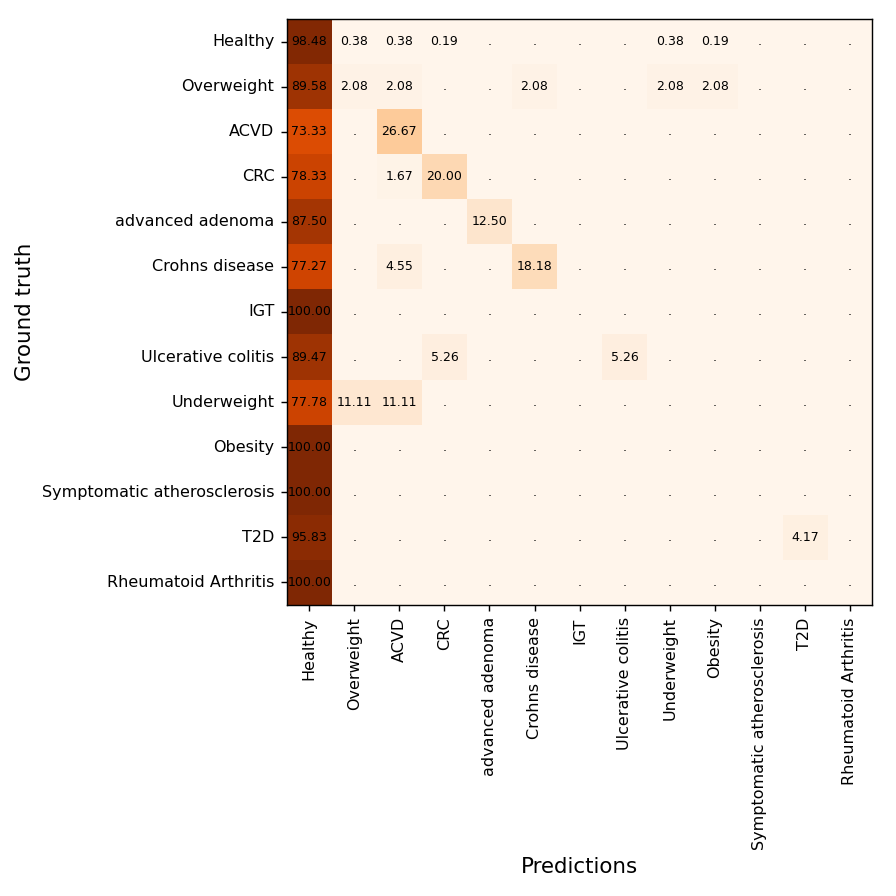

In [10]:
clf = RFC(n_estimators=1000, random_state=SEED)
clf.fit(X_train, y_train)

print(balanced_accuracy_score(y_test, clf.predict(X_test)))

cm(y_test, clf.predict(X_test))

Using weighting doesn't help

0.11692737087473928


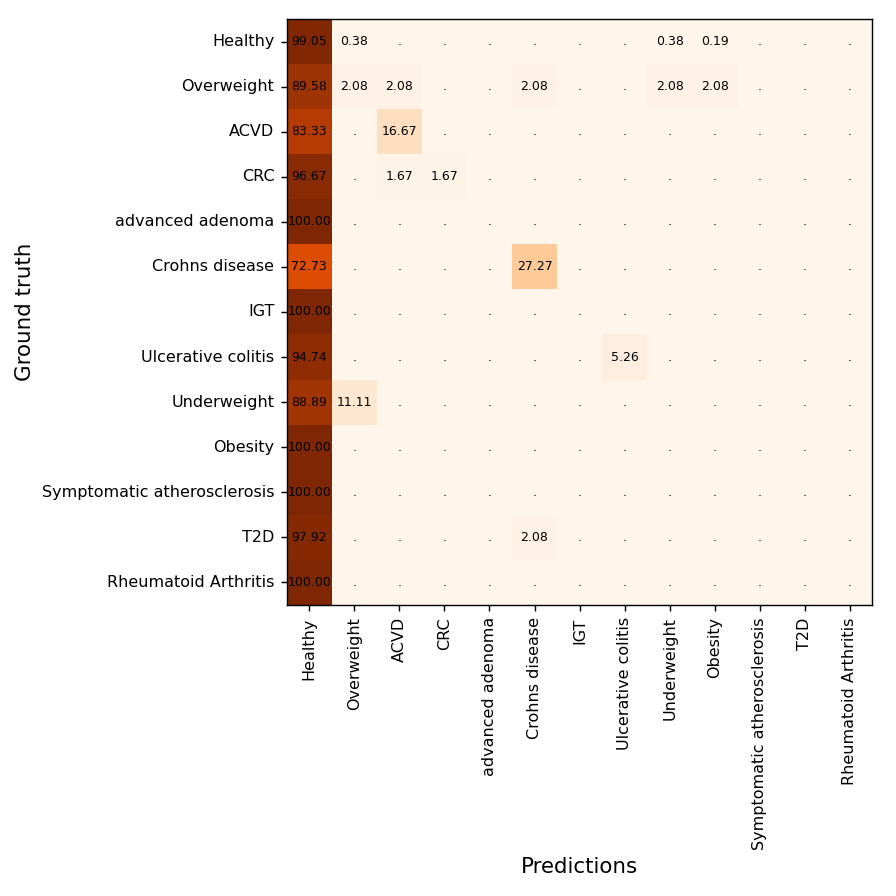

In [11]:
clf = RFC(n_estimators=1000, random_state=SEED, class_weight='balanced')
clf.fit(X_train, y_train)

print(balanced_accuracy_score(y_test, clf.predict(X_test)))

cm(y_test, clf.predict(X_test))

XGBoost by default achieves much better performance

c:\users\mkoziarski\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.27668745083605767


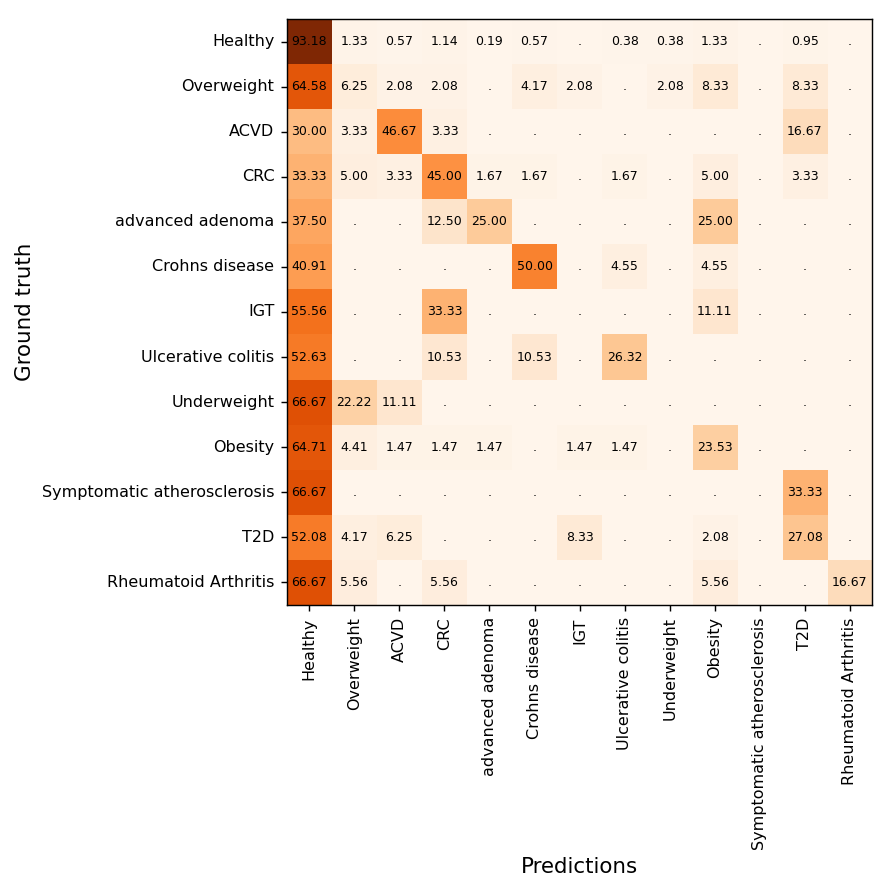

In [12]:
clf = XGBC(n_estimators=1000, random_state=SEED)
clf.fit(X_train, y_train)

print(balanced_accuracy_score(y_test, clf.predict(X_test)))

cm(y_test, clf.predict(X_test))

Single TabNet (either weighted or unweighted) outperforms RF, but is worse than XGB; TabNet bagging would likely achieve better results


Early stopping occured at epoch 403 with best_epoch = 303 and best_val_0_balanced_accuracy = 0.25785
Best weights from best epoch are automatically used!
0.1703299667308955


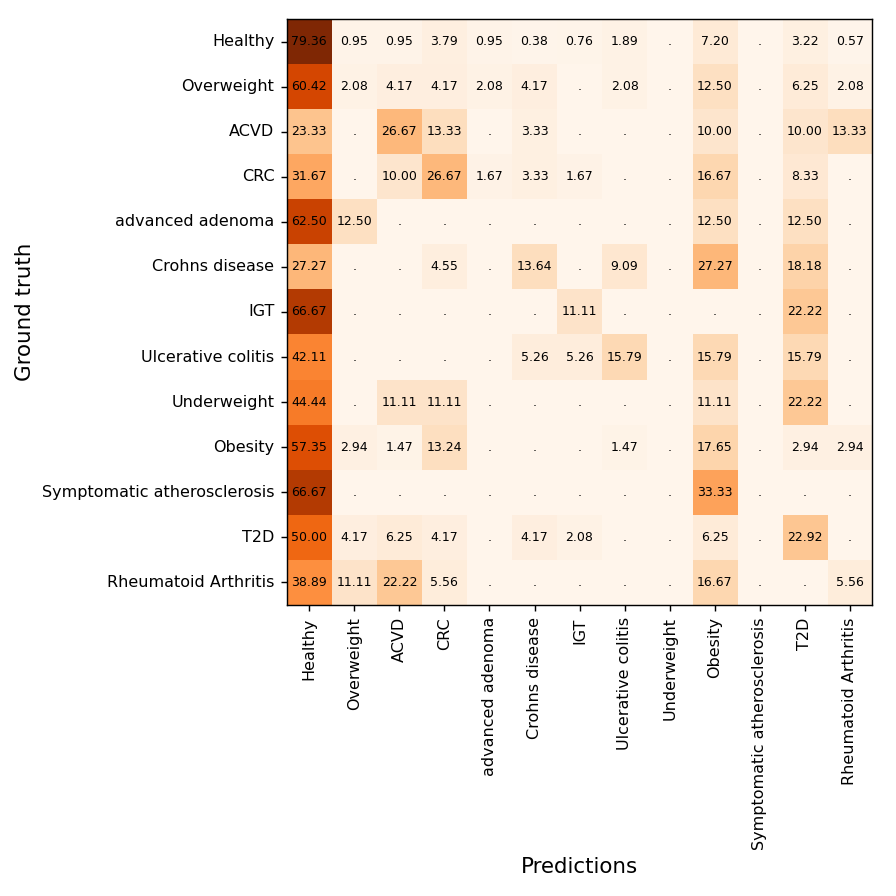

In [13]:
X_train_, X_val, y_train_, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)

clf = TNC(seed=SEED, verbose=0)
clf.fit(
    X_train_, y_train_, 
    eval_set=[(X_val, y_val)], 
    eval_metric=['balanced_accuracy'], 
    patience=100, max_epochs=500
)

print(balanced_accuracy_score(y_test, clf.predict(X_test)))

cm(y_test, clf.predict(X_test))


Early stopping occured at epoch 248 with best_epoch = 148 and best_val_0_balanced_accuracy = 0.28029
Best weights from best epoch are automatically used!
0.18050296366859836


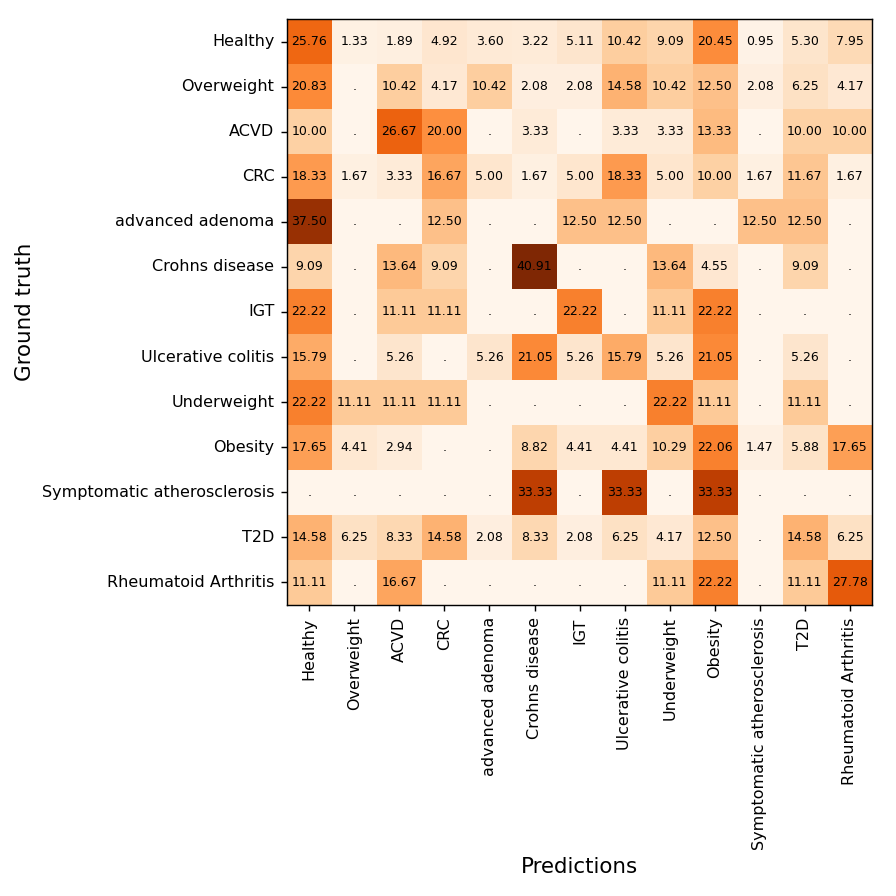

In [14]:
X_train_, X_val, y_train_, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)

clf = TNC(seed=SEED, verbose=0)
clf.fit(
    X_train_, y_train_, 
    eval_set=[(X_val, y_val)], 
    eval_metric=['balanced_accuracy'], 
    patience=100, max_epochs=500,
    weights=1
)

print(balanced_accuracy_score(y_test, clf.predict(X_test)))

cm(y_test, clf.predict(X_test))

Using oversampling significantly improves the performance of RF; oversampling metaparameter experimentally chosen based on a single fold, parameter selection for each fold during cross-validation would possibly improve the performance

  0%|          | 0/8 [00:00<?, ?it/s]

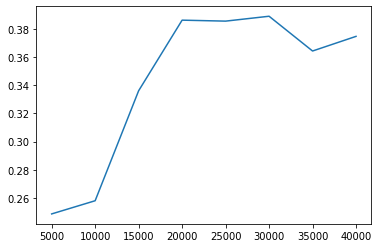

In [15]:
X_train_, X_val, y_train_, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)

scores = {}
energies = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]

for energy in tqdm(energies):
    if scores.get(energy) is None:
        X_train_resampled, y_train_resampled = CCR(energy, seed=SEED).fit_sample(X_train_, y_train_)

        clf = RFC(n_estimators=200, random_state=SEED)
        clf.fit(X_train_resampled, y_train_resampled)

        scores[energy] = balanced_accuracy_score(y_val, clf.predict(X_val))

plt.plot(energies, [scores[e] for e in energies])

0.29884508336520715


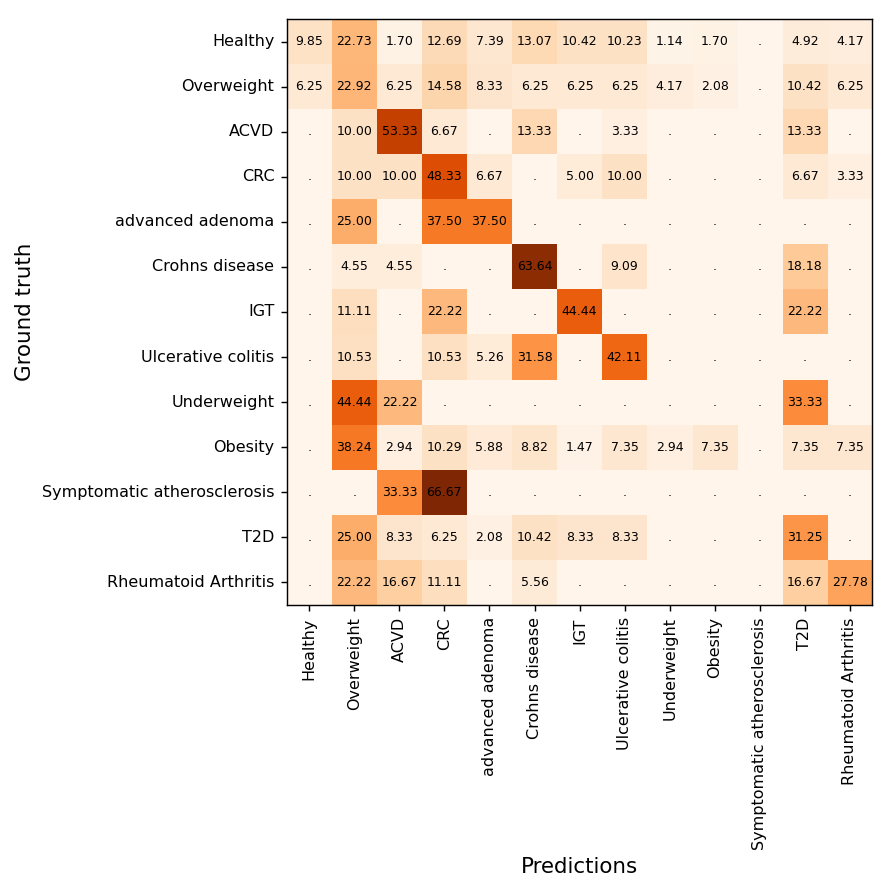

In [16]:
best_energy = max(scores, key=scores.get)

X_train_, y_train_ = CCR(best_energy, seed=SEED).fit_sample(X_train, y_train)

clf = RFC(n_estimators=1000, random_state=SEED)
clf.fit(X_train_, y_train_)

print(balanced_accuracy_score(y_test, clf.predict(X_test)))

cm(y_test, clf.predict(X_test))

In [17]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

scores = []
fold_ground_truth = []
fold_predictions = []

for train_index, test_index in tqdm(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train_, y_train_ = CCR(best_energy, seed=SEED).fit_sample(X_train, y_train)

    clf = RFC(n_estimators=1000, random_state=SEED)
    clf.fit(X_train_, y_train_)
    
    predictions = clf.predict(X_test)
    score = balanced_accuracy_score(y_test, predictions)
    
    scores.append(score)
    fold_ground_truth.append(y_test)
    fold_predictions.append(predictions)

print(f'BAC = {np.mean(scores):.4f} +- {np.std(scores):.4f}')

ground_truth = np.concatenate(fold_ground_truth)
predictions = np.concatenate(fold_predictions)

cm(ground_truth, predictions)

|          | 0/? [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/8 [00:00<?, ?it/s]

c:\users\mkoziarski\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:26:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:45:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

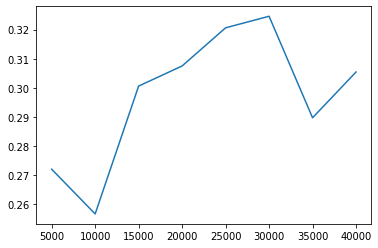

In [19]:
X_train_, X_val, y_train_, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)

scores = {}
energies = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]

for energy in tqdm(energies):
    if scores.get(energy) is None:
        X_train_resampled, y_train_resampled = CCR(energy, seed=SEED).fit_sample(X_train_, y_train_)

        clf = XGBC(n_estimators=200, random_state=SEED)
        clf.fit(X_train_resampled, y_train_resampled)

        scores[energy] = balanced_accuracy_score(y_val, clf.predict(X_val))

plt.plot(energies, [scores[e] for e in energies])

[19:43:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.3987676539147128


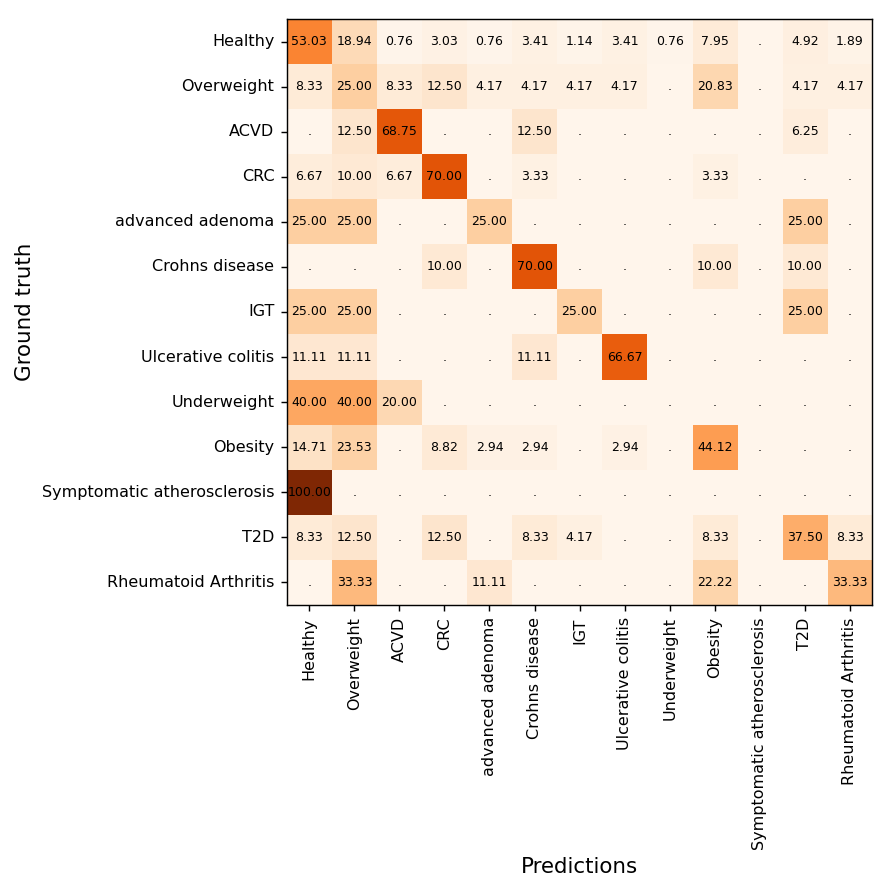

In [20]:
best_energy = max(scores, key=scores.get)

X_train_, y_train_ = CCR(best_energy, seed=SEED).fit_sample(X_train, y_train)

clf = XGBC(n_estimators=1000, random_state=SEED)
clf.fit(X_train_, y_train_)

print(balanced_accuracy_score(y_test, clf.predict(X_test)))

cm(y_test, clf.predict(X_test))

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

scores = []
fold_ground_truth = []
fold_predictions = []

for train_index, test_index in tqdm(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train_, y_train_ = CCR(best_energy, seed=SEED).fit_sample(X_train, y_train)

    clf = XGBC(n_estimators=1000, random_state=SEED)
    clf.fit(X_train_, y_train_)
    
    predictions = clf.predict(X_test)
    score = balanced_accuracy_score(y_test, predictions)
    
    scores.append(score)
    fold_ground_truth.append(y_test)
    fold_predictions.append(predictions)

print(f'BAC = {np.mean(scores):.4f} +- {np.std(scores):.4f}')

ground_truth = np.concatenate(fold_ground_truth)
predictions = np.concatenate(fold_predictions)

cm(ground_truth, predictions)